## Visualize sidewalk polygons

In [1]:
import matplotlib.pyplot as plt

import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.las_utils as las_utils
from sidewalk_filter import *

In [2]:
tilecode = '2386_9702'
((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=1)

# Create reader for BGT sidewalk part polygons.
bgt_road_file = '../datasets/bgt/bgt_voetpad_demo.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

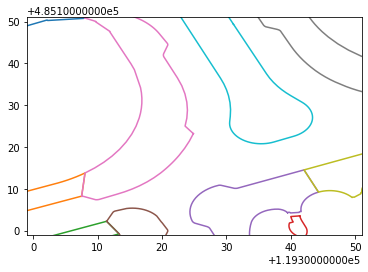

In [3]:
for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.plot(x,y)
    
    # Get current axis and then set its limits
    ax = plt.gca()
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

## 2D Visualization of obstacles

In [4]:
import pandas as pd
from pathlib import Path
import ast
from shapely.geometry import Polygon

def get_obstacles():
    """
    Return a list of polygons representing each of the roads found in
    the area represented by the given CycloMedia tile-code.
    """
    obstacles = [ast.literal_eval(poly) for poly in df_obstacles.obstacle.values]
    poly_obstacles = [Polygon(rds)
                      for rds in obstacles]
    return poly_obstacles

bgt_obstacle_file = '../datasets/bgt/bgt_obstacle_demo.csv'
df_obstacles = pd.read_csv(Path(bgt_obstacle_file))
obstacles = get_obstacles()

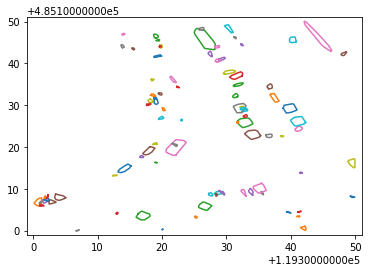

In [5]:
for obstacle in obstacles:
    x,y = obstacle.exterior.xy
    plt.plot(x,y)
    
    # Get current axis and then set its limits
    ax = plt.gca()
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

## Plot exterior and interior polygons

In [6]:
# Divide obstacles from sidewalk polygons
sidewalk_minus_obstacles = []
for poly_sidewalk in sidewalk_polygons:
    donuts = []
    for poly_obstacle in obstacles:
        if poly_sidewalk.contains(poly_obstacle):
            donuts.append(poly_obstacle)
    
    # Create interior polygons
    sidewalk_obstacles = poly_sidewalk
    for poly in donuts:
        sidewalk_obstacles -= poly
        
    sidewalk_minus_obstacles.append(sidewalk_obstacles)

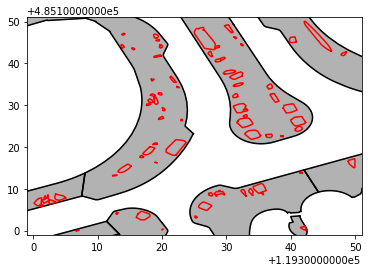

In [7]:
# Plot the result
for sidewalk_obstacles in sidewalk_minus_obstacles:
    x, y = sidewalk_obstacles.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)

    plt.plot(x, y, c="black")
    interiors = sidewalk_obstacles.interiors
    for interior in interiors:
        x, y = interior.xy
        plt.plot(x, y, c="red")
    
    # Get current axis and then set its limits
    ax = plt.gca()
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

In [8]:
import geopandas as gpd

# save the new polygons
df = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
df['geometry'] = sidewalk_minus_obstacles
df.crs = {'init': 'epsg:28992'} #local crs
df.to_file('../datasets/dataframe.shp') 

/opt/anaconda3/envs/new/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
